# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
# There's only two columns with missing values and it's a miniscule amount, so I'm just going to remove those rows

df_reviews = df_reviews.dropna()
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [7]:
print(df_reviews.duplicated().sum())

0


<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Done? 
    
I'm not really sure what else I could do, except for maybe dropping a few unnecessary columns, but I'm just going to isolate the columns I need later anyway
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Yeah, that's enough:)
</div>

## EDA

Let's check the number of movies and reviews over years.

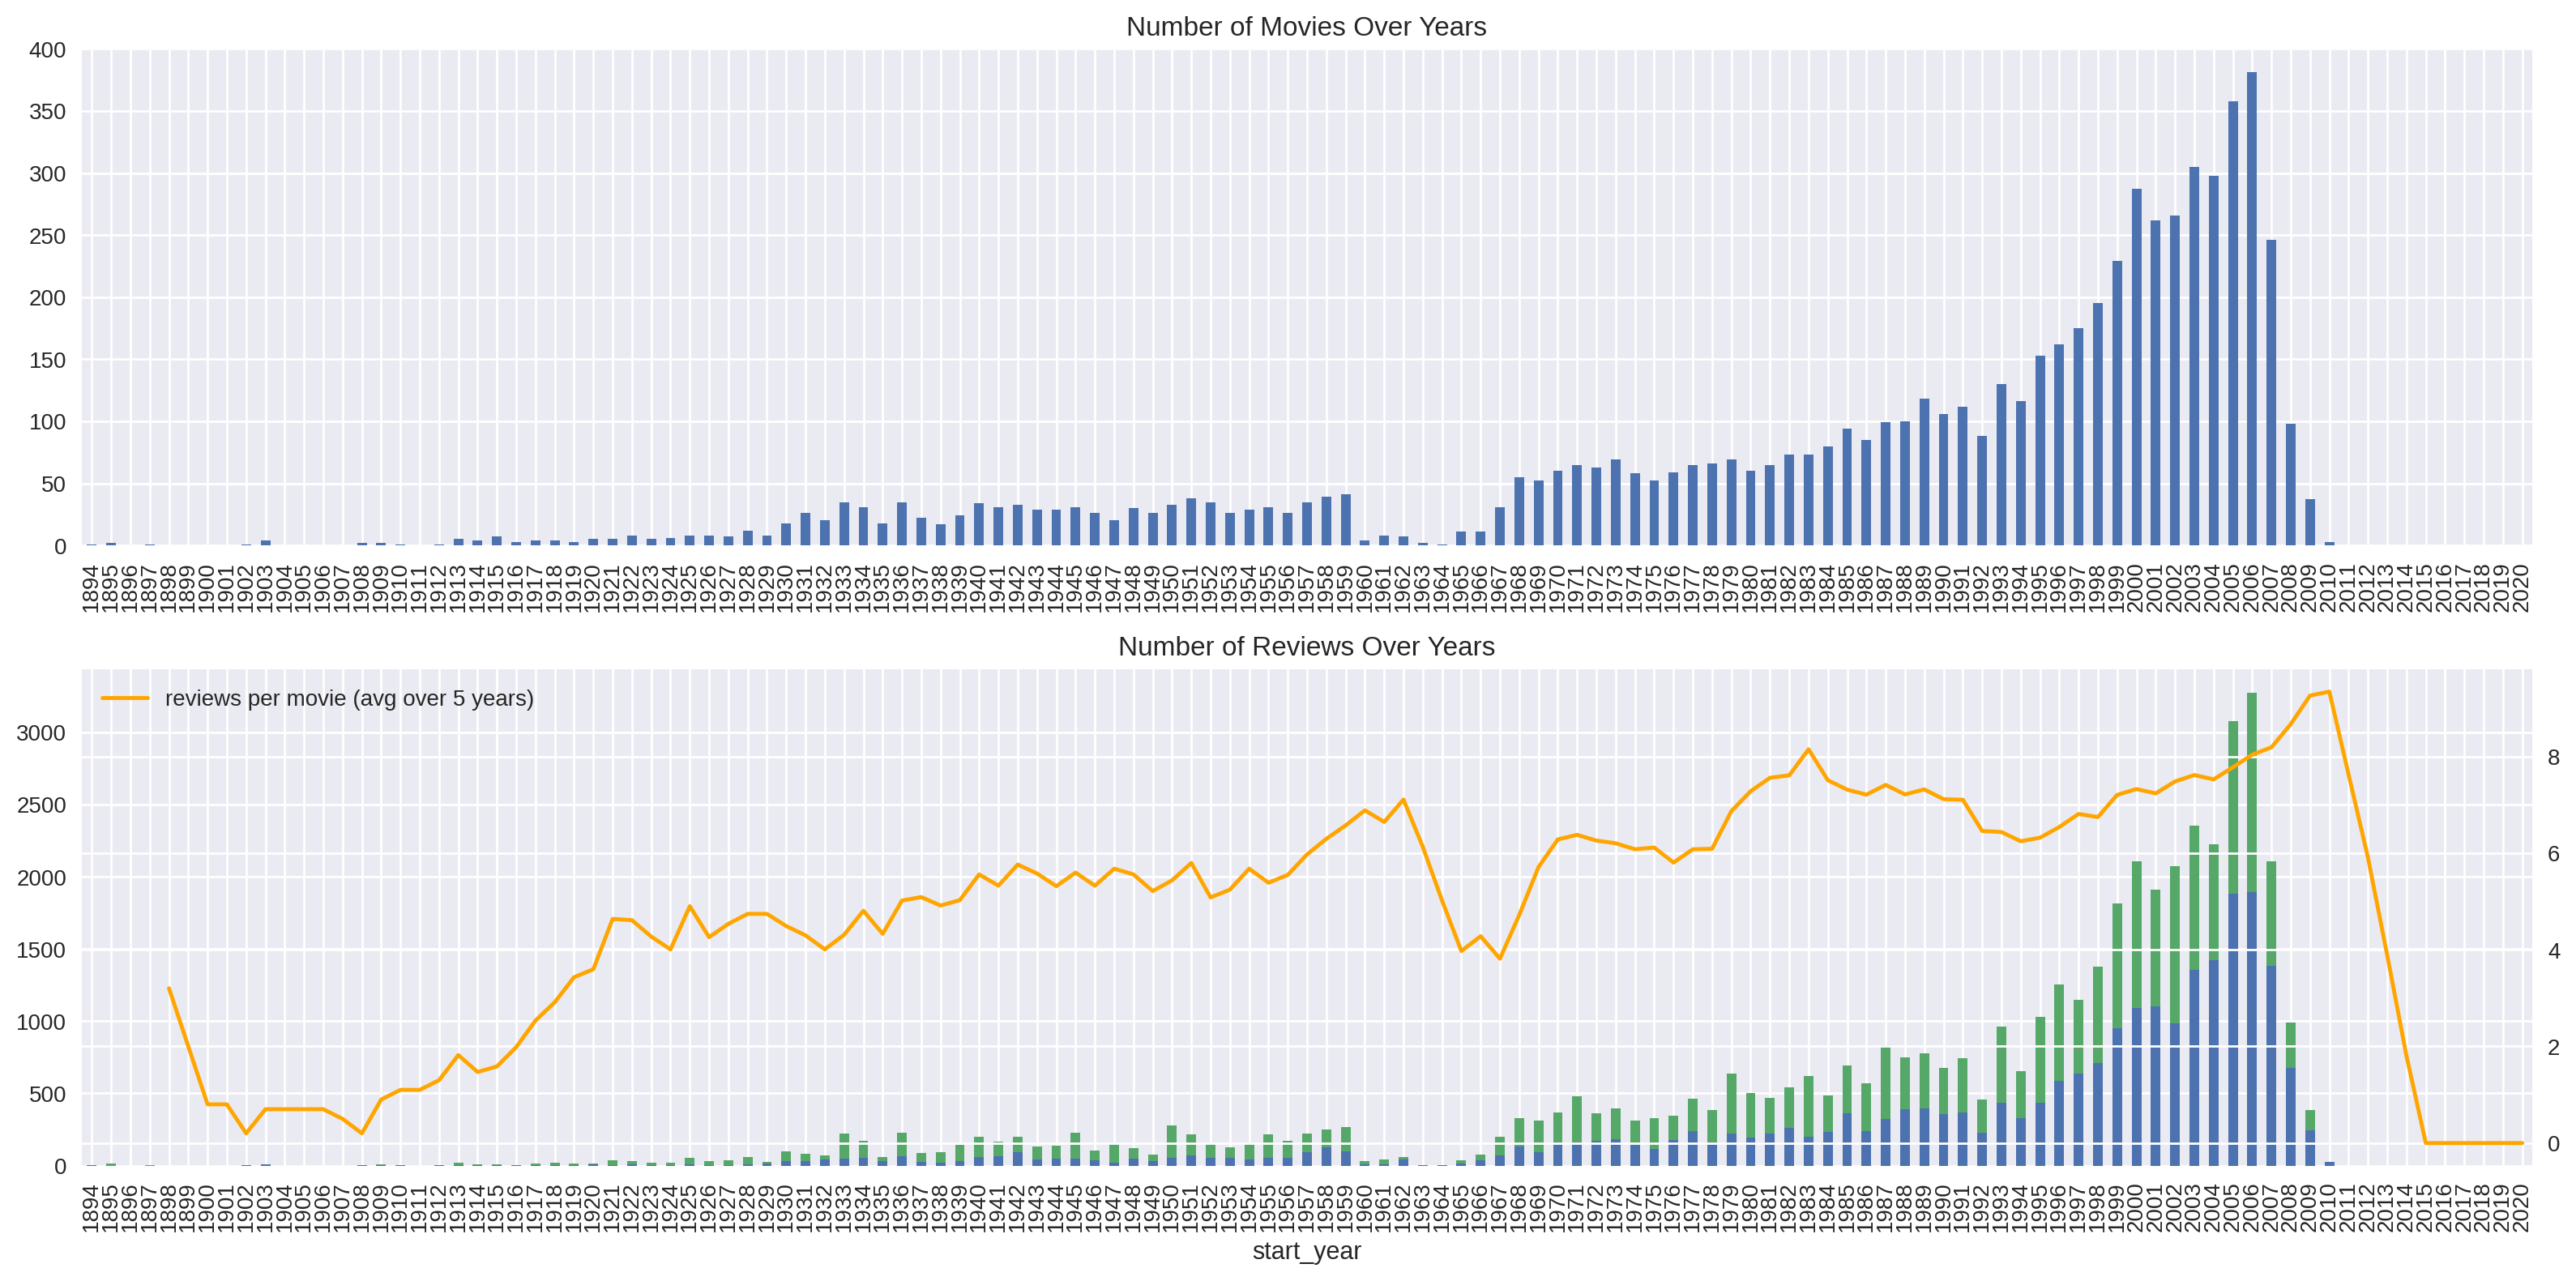

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

There seems to be a gap in reviews throughout the 1960's, but I don't think that will affect the training.
The number of reviews is constantly trending upwards until the more recent years which could be because of a lack of things to review?

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

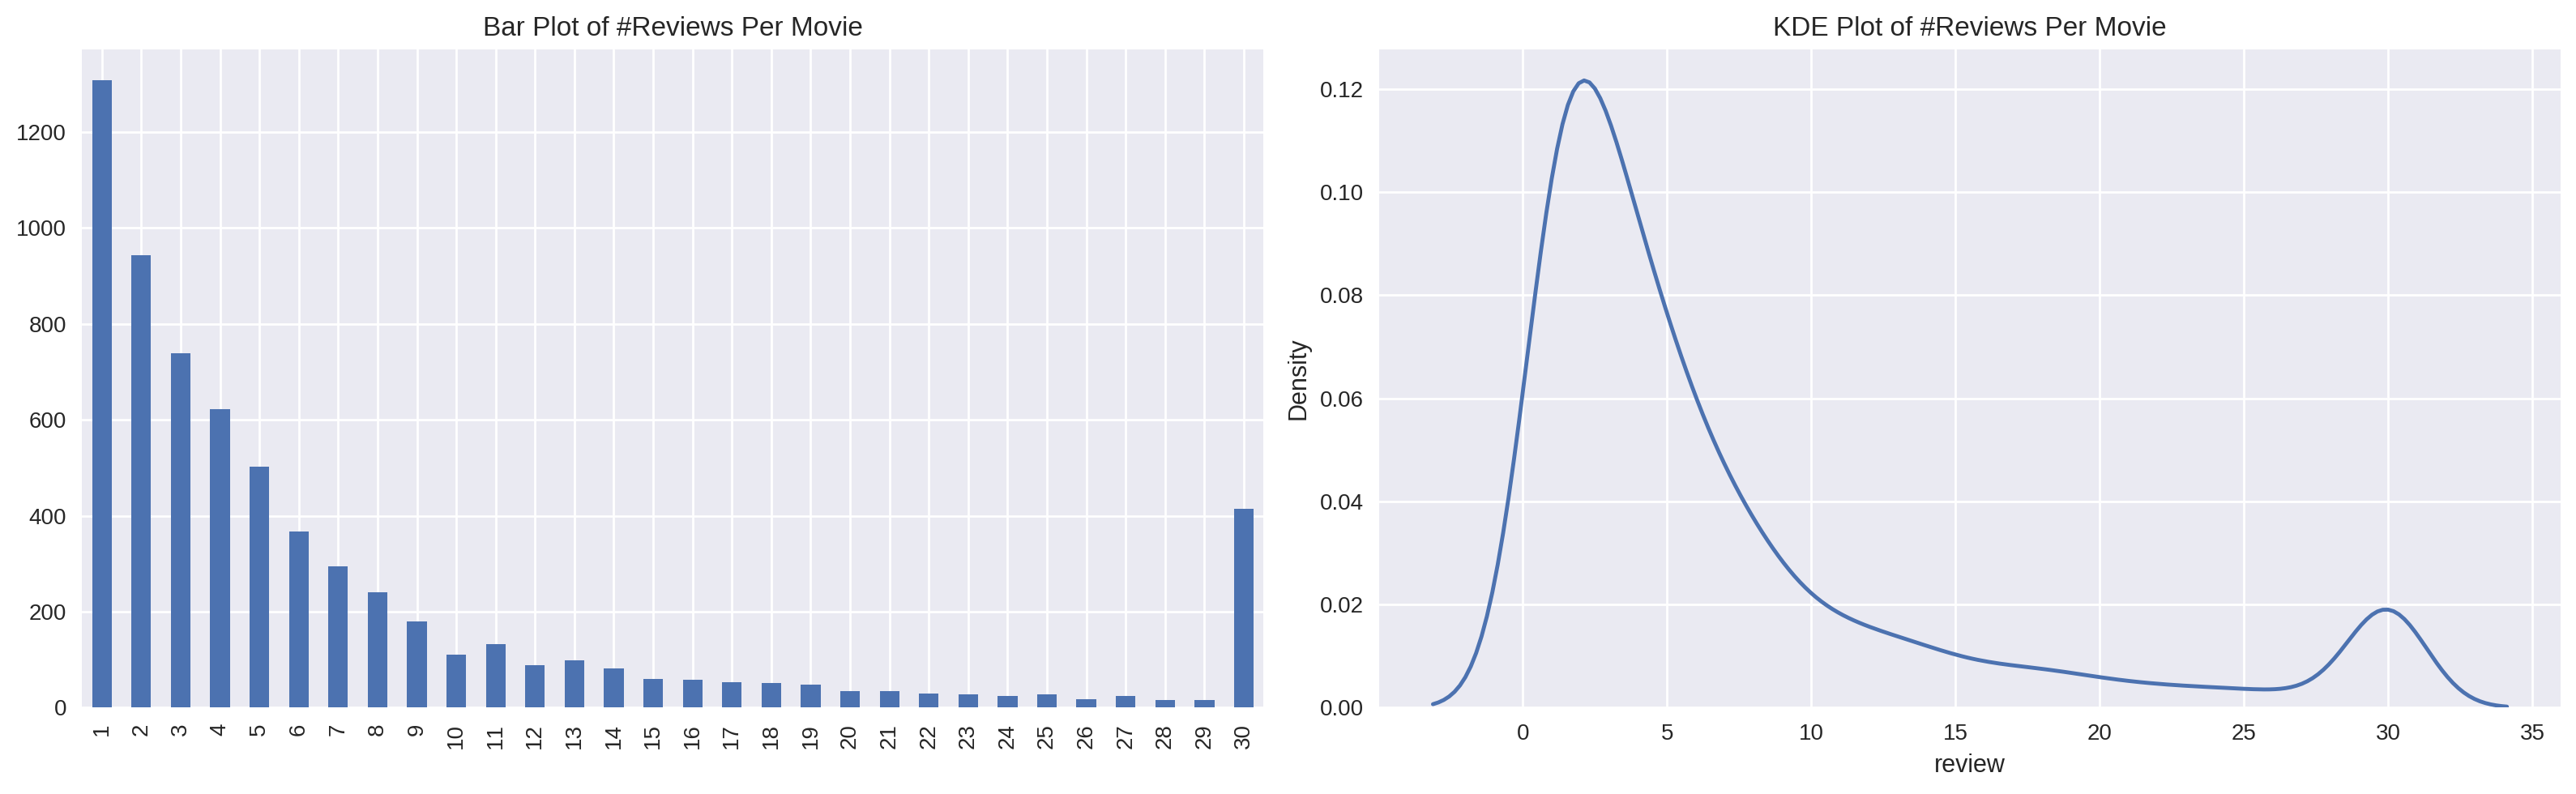

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

I think the class imbalance here is small enough to not warrant any adjustments

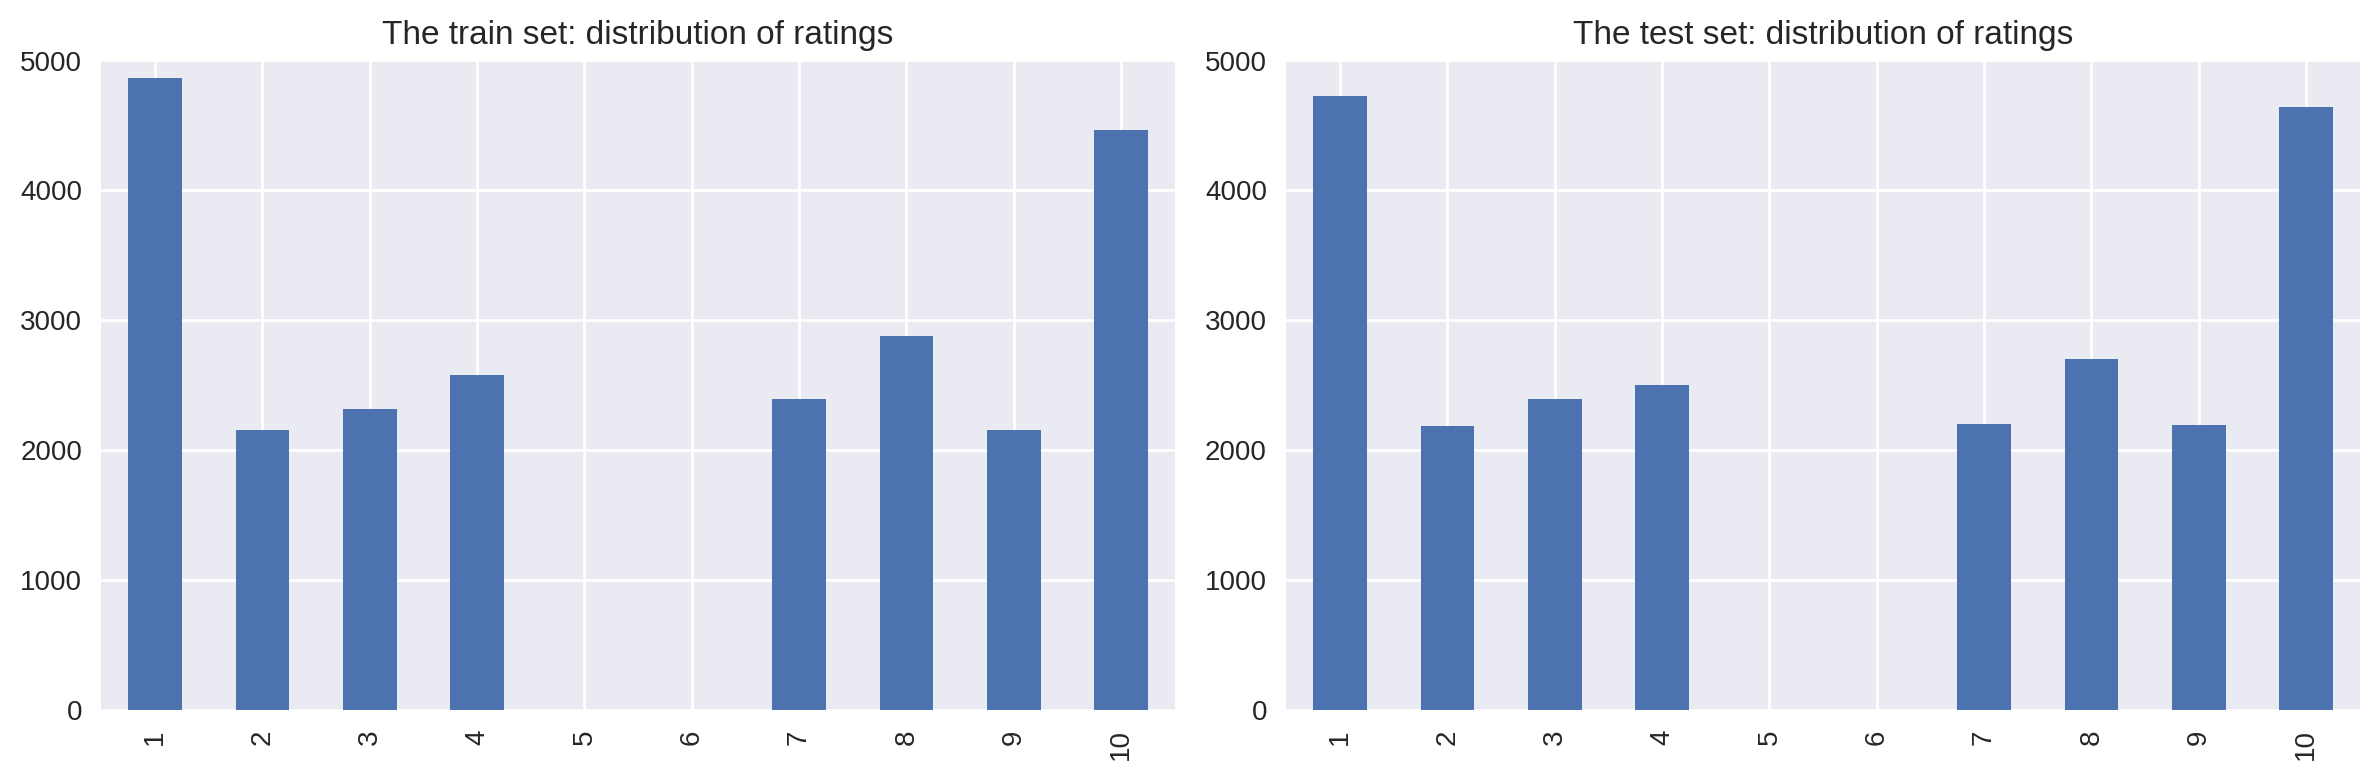

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The graphs are very similar, so like I said before, I don't think the slight differences in the number of scores for each set will change the training much.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


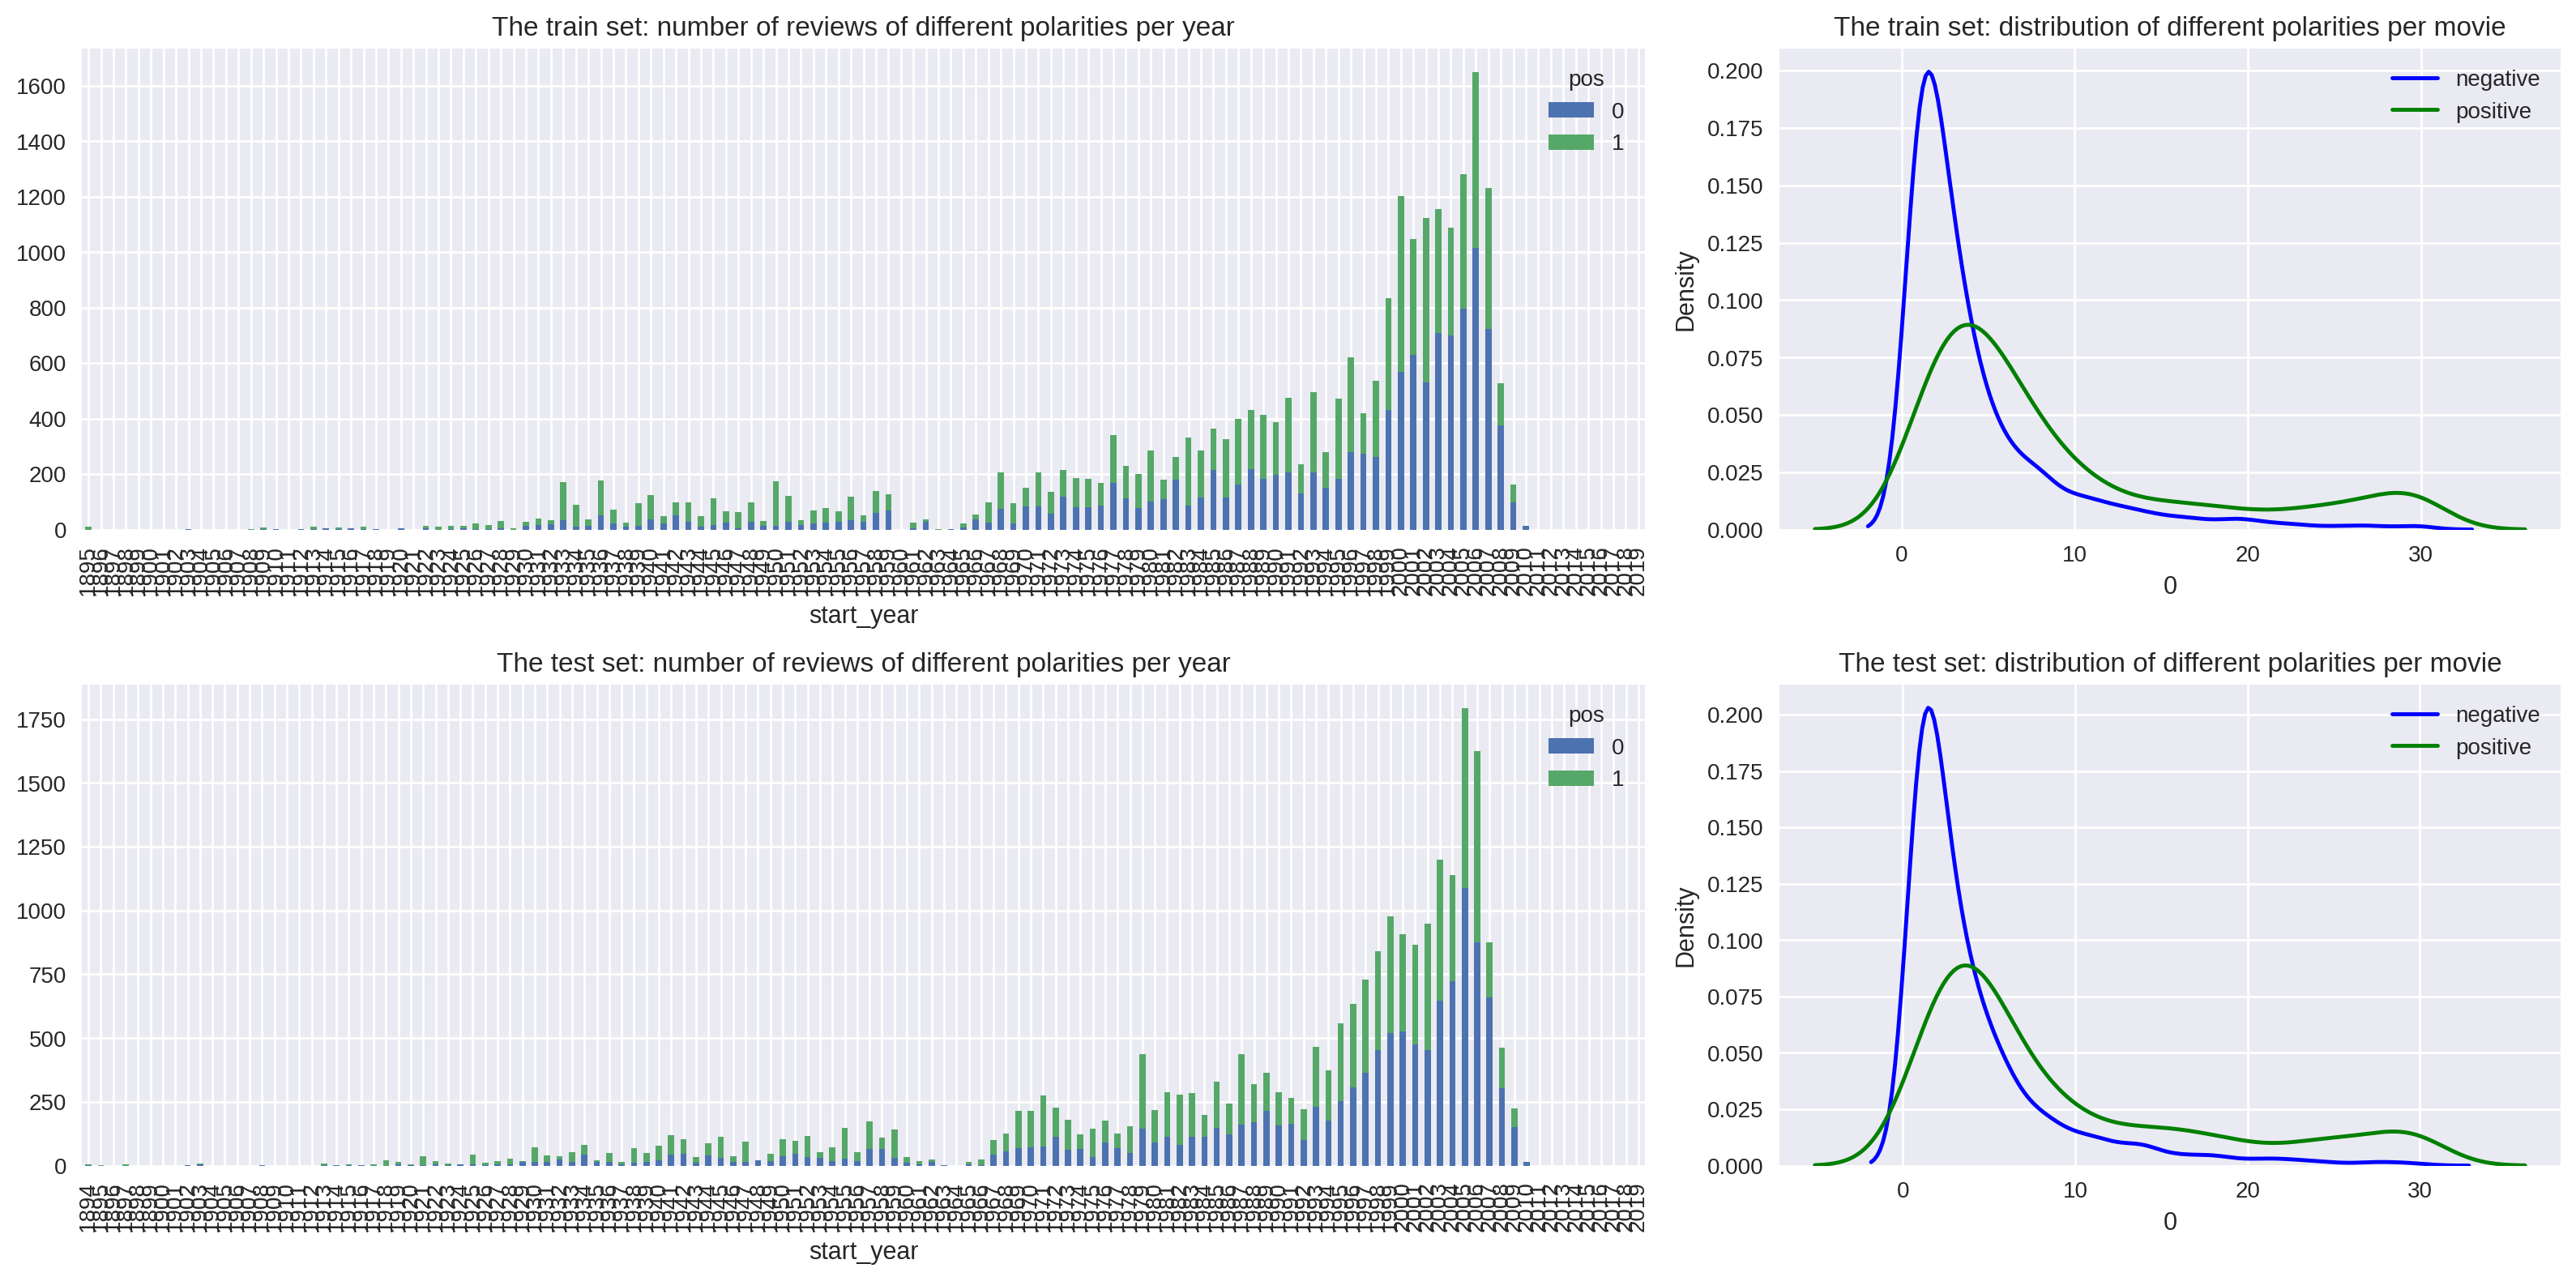

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

In this graph, it does show a noticable difference between the two sets. Although, I think the more important variable is the balance between the positive and negative scores. Most years have a ~equal number of positive and negative scores, which I think will aid in the training of the models.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove digits and punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [15]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)
print(df_reviews['review_norm'].shape)

(47329,)


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Good job! 
</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)
print(train_target.shape)
print(test_target.shape)

(23796, 18)
(23533, 18)
(23796,)
(23533,)


## Working with models

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
# Initialize Dummy Model with 'stratified' strategy
dummy = DummyClassifier(strategy='stratified')

# Train the model
dummy.fit(df_reviews_train, train_target)

# Make predictions
dummy_predicted = dummy.predict(test_target)

          train  test
Accuracy   0.50   0.5
F1         0.50   0.5
APS        0.50   0.5
ROC AUC    0.51   0.5


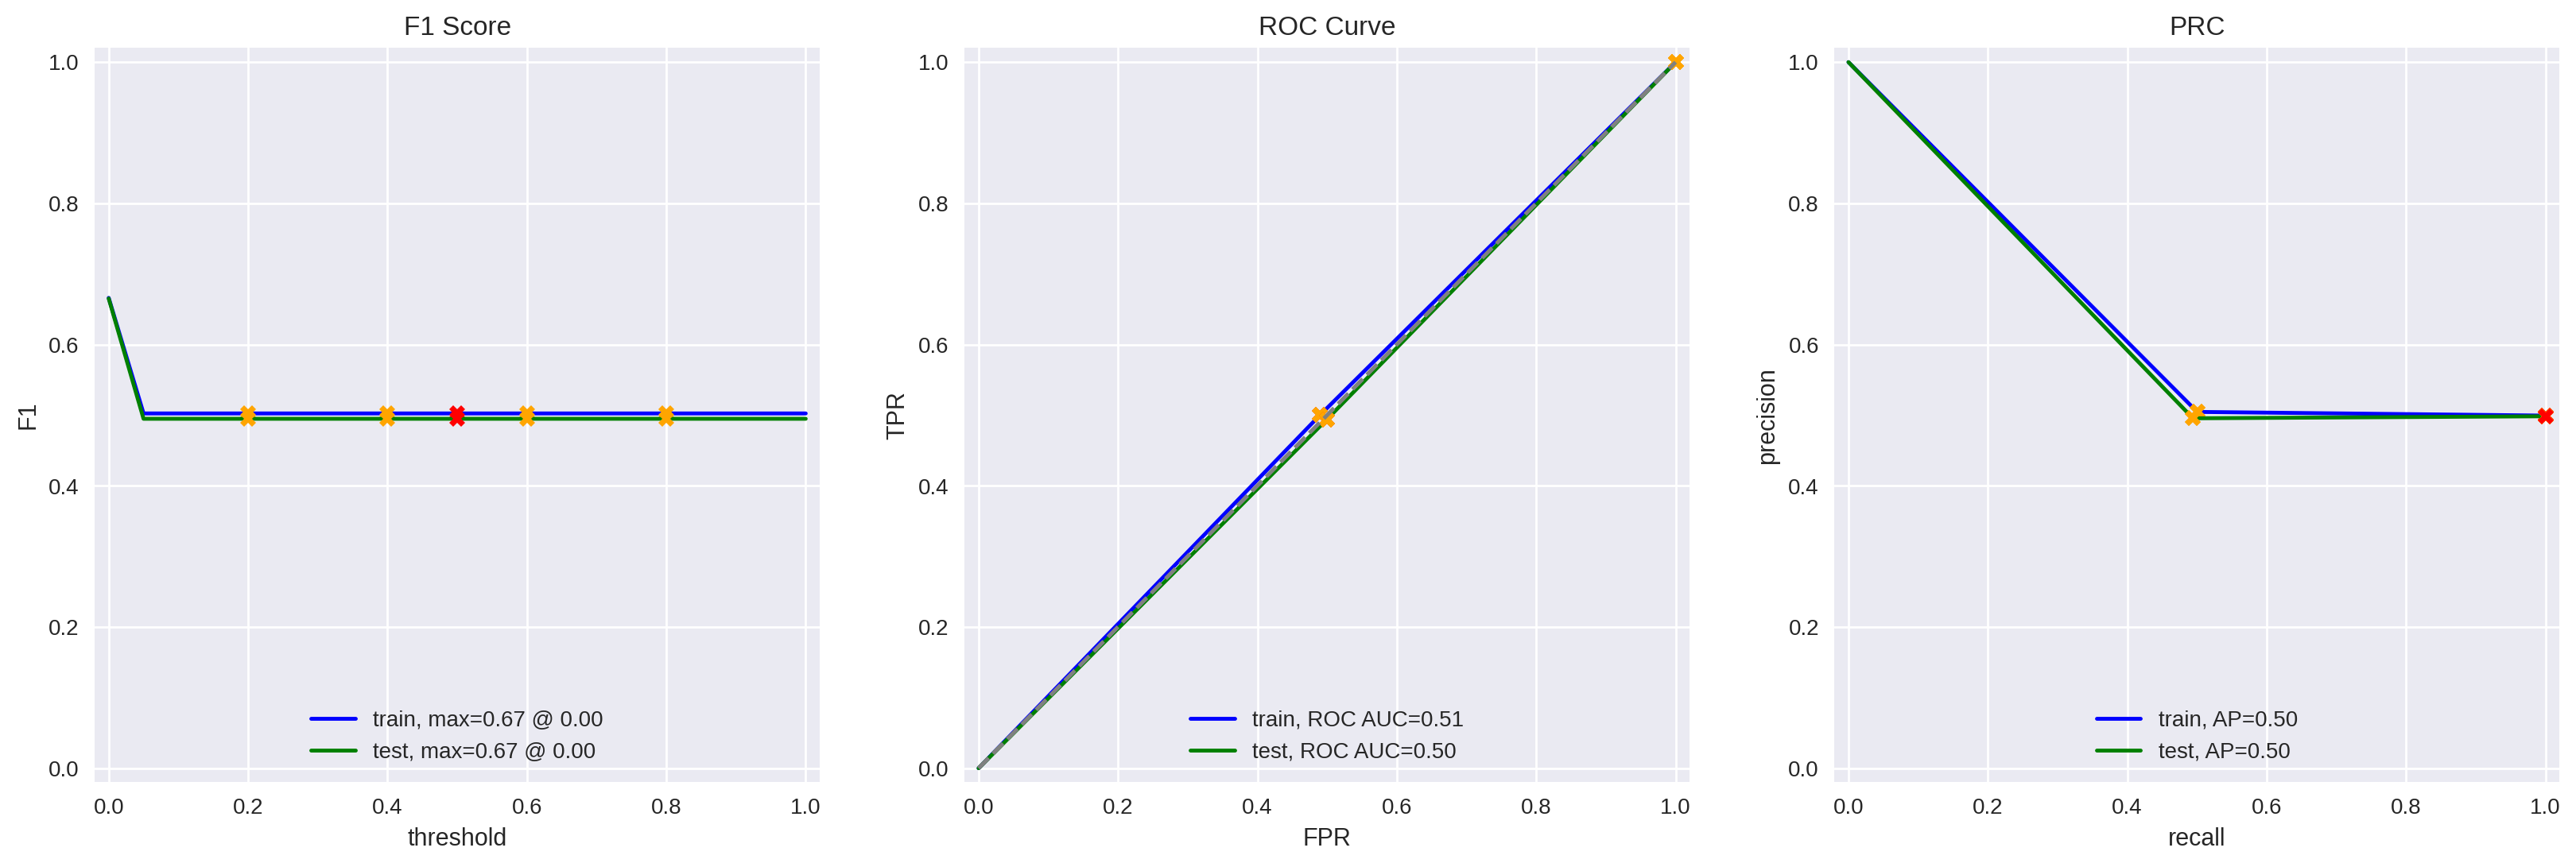

In [19]:
evaluate_model(dummy, df_reviews_train, train_target, df_reviews_test, test_target)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

print(train_features_1.shape)
print(train_target.shape)

(23796, 105801)
(23796,)


In [22]:
# Logistic Regression Model

# Initialize and train
logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_features_1, train_target)

# Make predictions
logreg_pred = logreg.predict(test_features_1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


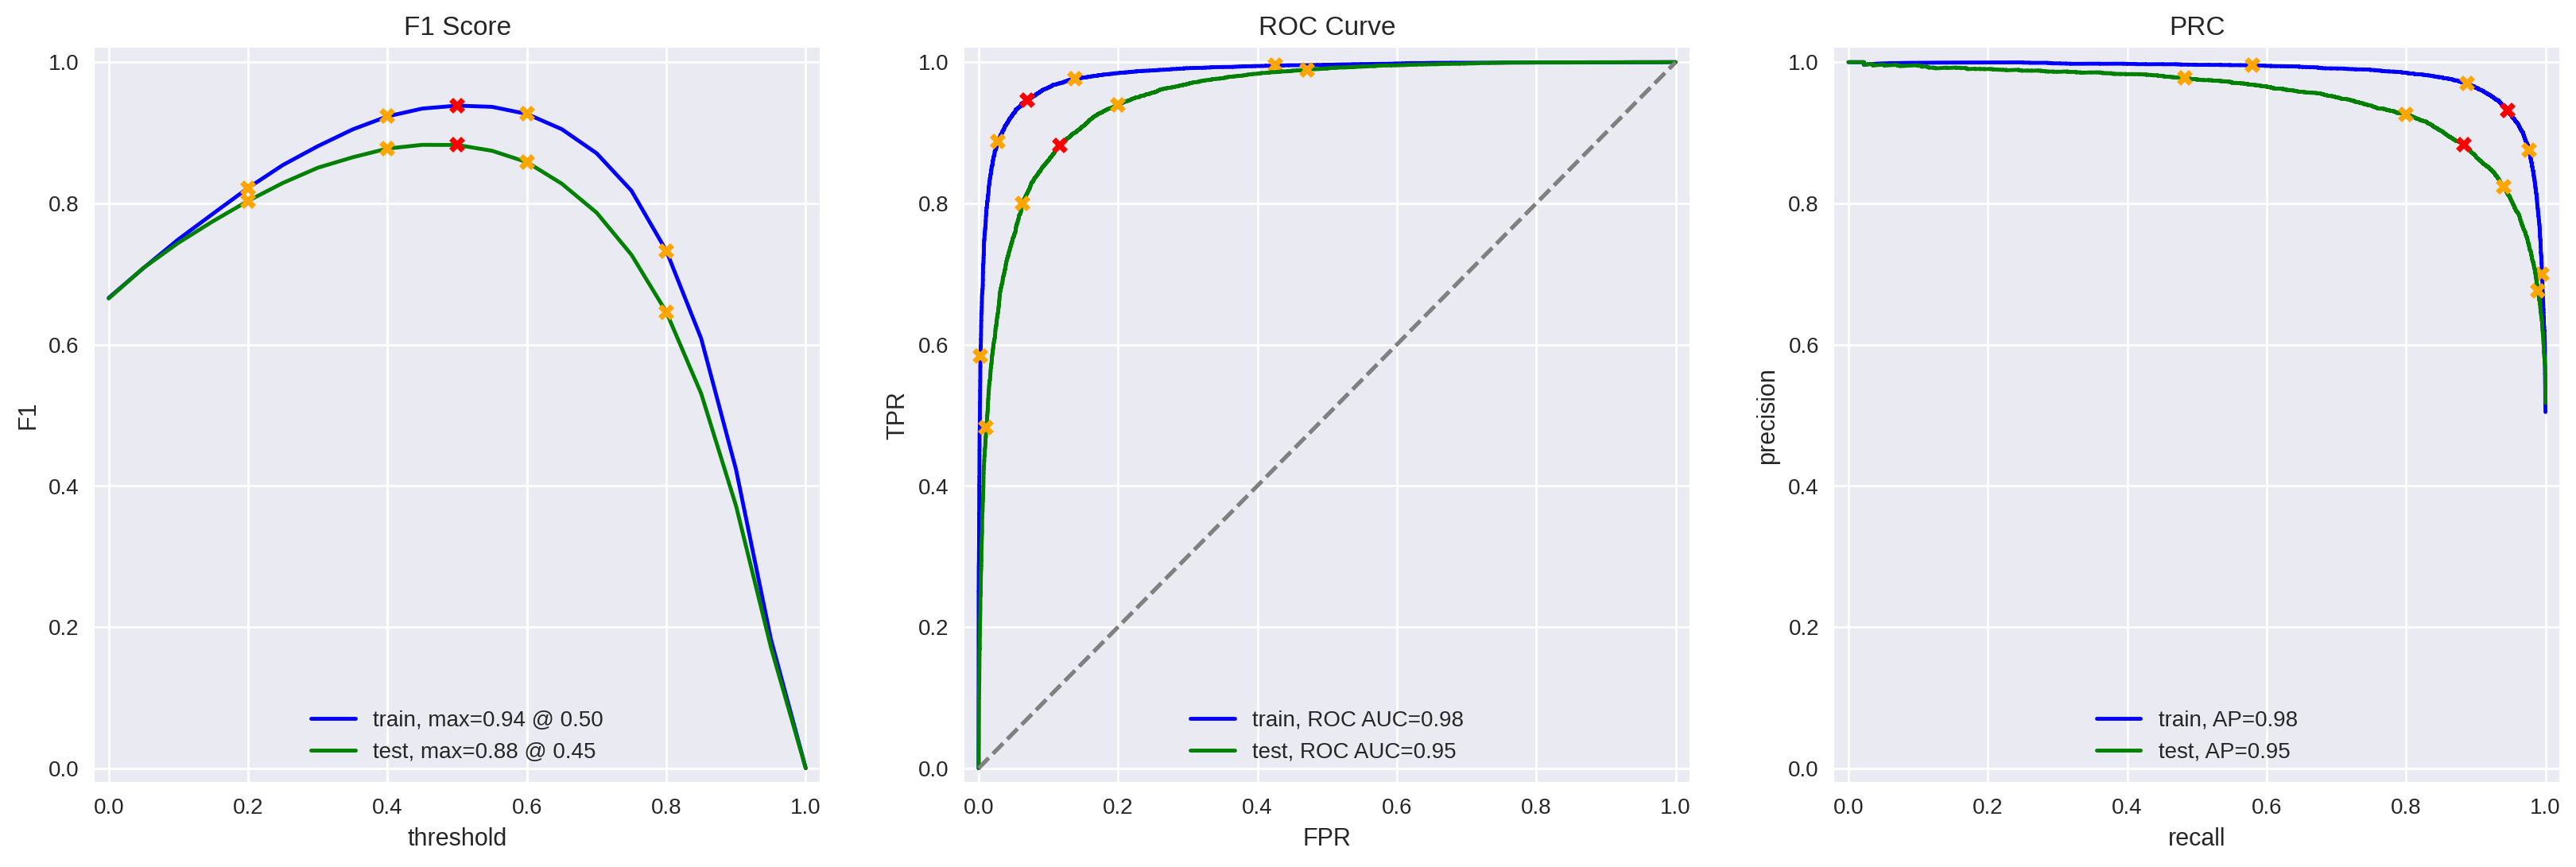

In [23]:
evaluate_model(logreg, train_features_1, train_target, test_features_1, test_target)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct 
</div>

### Model 3 - spaCy, TF-IDF and LR

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [26]:
# Repreprocess the data for spacy
df_reviews['review_preprocessed'] = df_reviews['review_norm'].apply(text_preprocessing_3)

# Split the data into train and test sets
train_data = df_reviews[df_reviews['ds_part'] == 'train'][['review_preprocessed', 'pos']]
test_data = df_reviews[df_reviews['ds_part'] == 'test'][['review_preprocessed', 'pos']]

spacy_features_train = train_data['review_preprocessed']
spacy_target_train = train_data['pos']
spacy_features_test = test_data['review_preprocessed']
spacy_target_test = test_data['pos']

In [27]:
# Vectorize
tfidf_vectorizer_spacy = TfidfVectorizer(stop_words=stop_words)
spacy_train_tfidf = tfidf_vectorizer_spacy.fit_transform(spacy_features_train)
spacy_test_tfidf = tfidf_vectorizer_spacy.transform(spacy_features_test)

In [28]:
# Logistic Regression Model with spacy
logreg2 = LogisticRegression(max_iter=1000)
logreg2.fit(spacy_train_tfidf, spacy_target_train)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


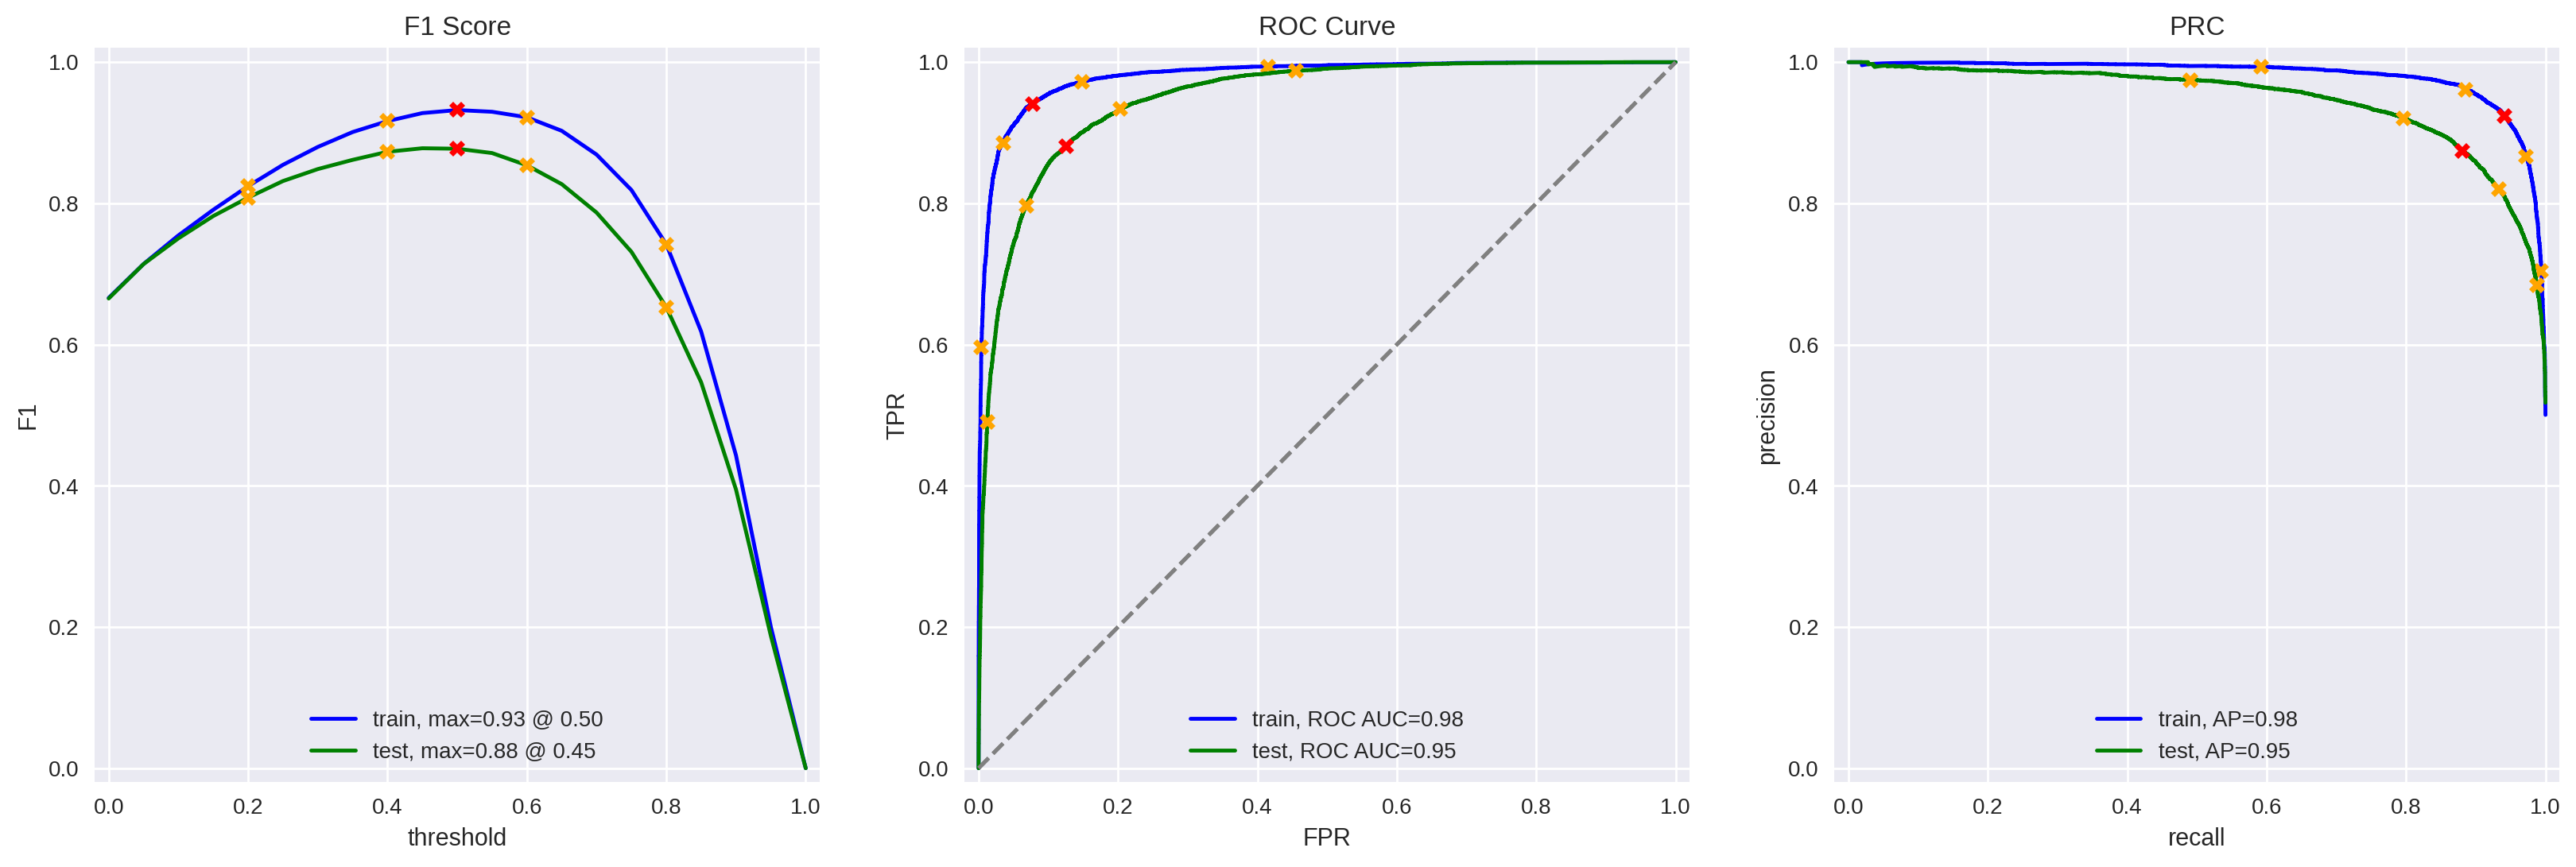

In [29]:
# Evaluate spacy logistic regression model
evaluate_model(logreg2, spacy_train_tfidf, spacy_target_train, spacy_test_tfidf, spacy_target_test)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [30]:
from lightgbm import LGBMClassifier

In [31]:
# Initialize and train model

# LightGBM Classifier
lgbm_classifier = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.2,
    n_estimators=100
)

# Train the model
lgbm_classifier.fit(spacy_train_tfidf, spacy_target_train, eval_set=[(spacy_train_tfidf, spacy_target_train), (spacy_test_tfidf, spacy_target_test)], early_stopping_rounds=10, verbose=False)

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.2, objective='binary')

          train  test
Accuracy   0.95  0.87
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


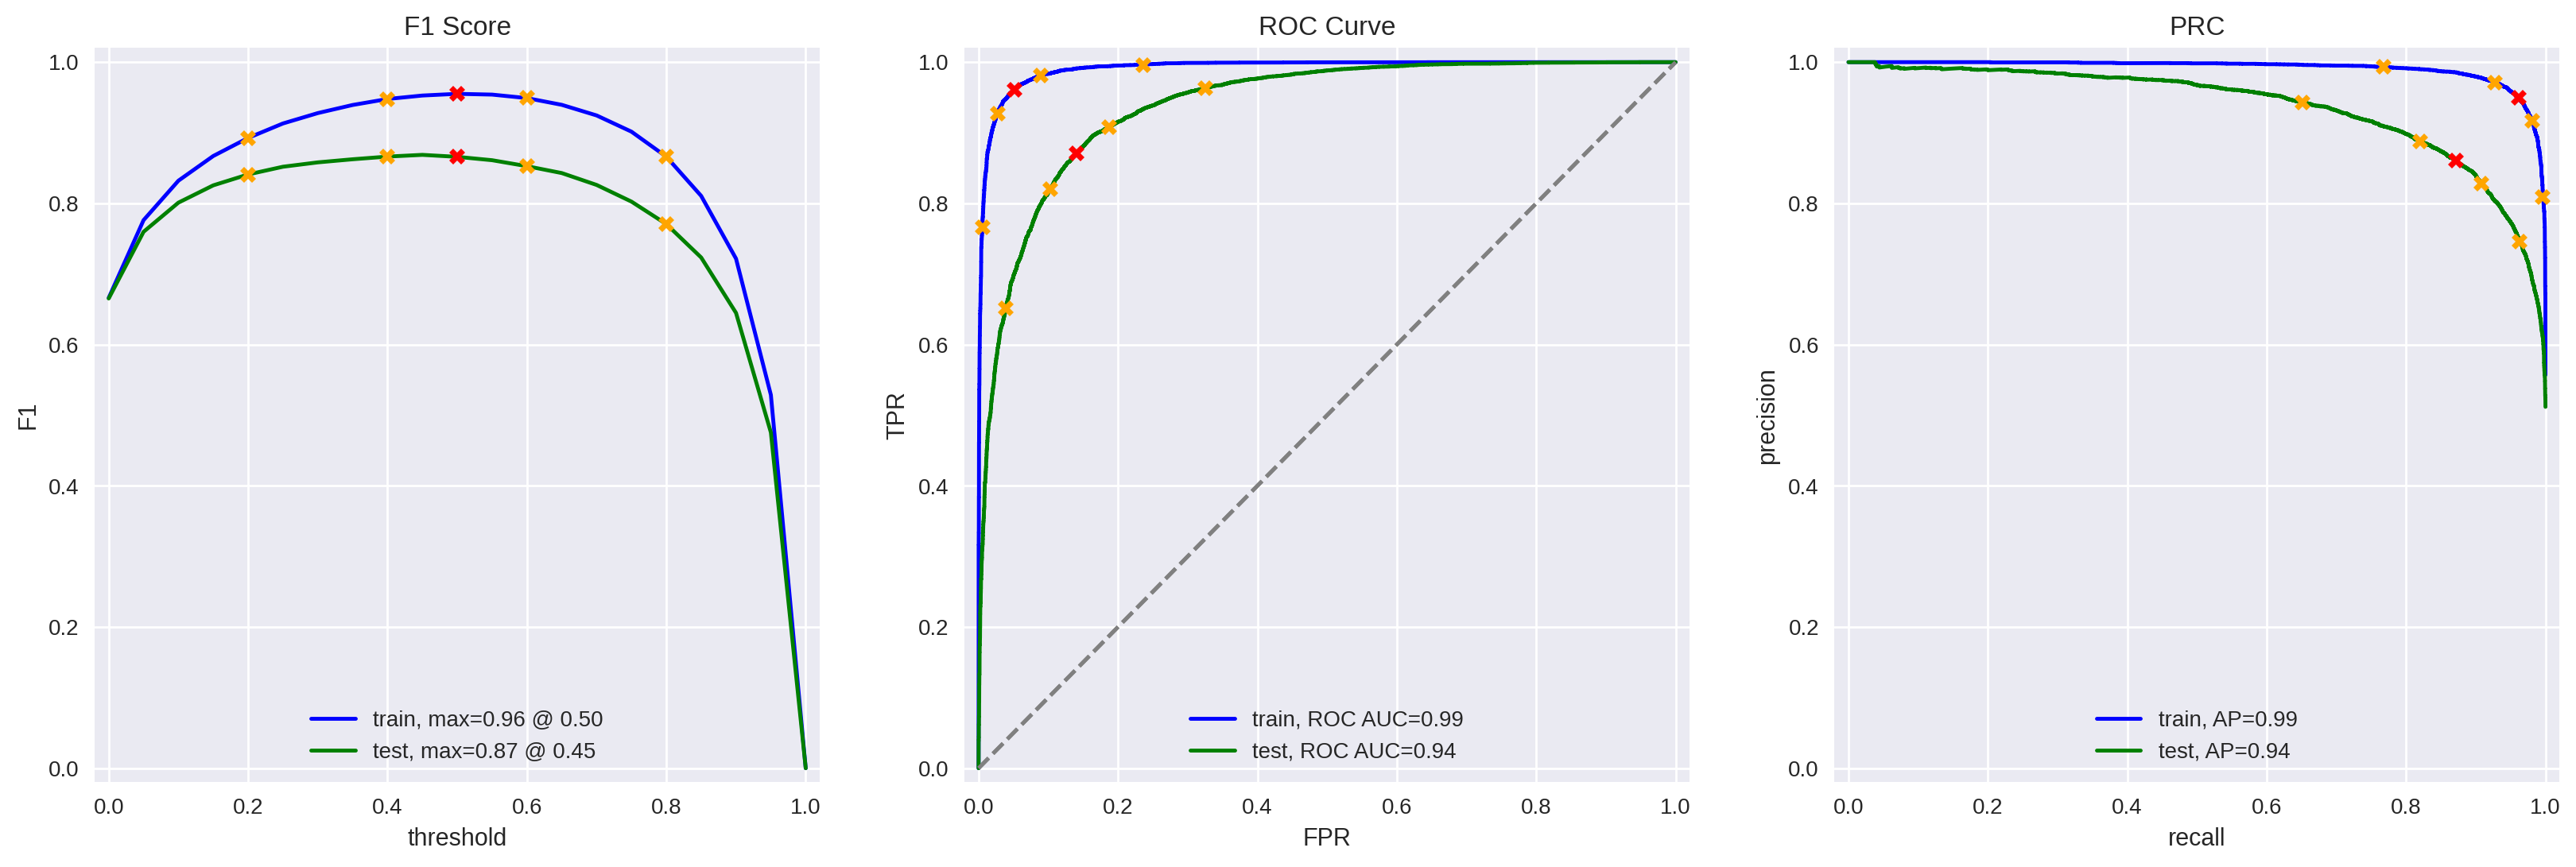

In [32]:
# Evaluate LGBM model
evaluate_model(lgbm_classifier, spacy_train_tfidf, spacy_target_train, spacy_test_tfidf, spacy_target_test)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct 
</div>

###  Model 9 - BERT

In [33]:
'''
import torch
import transformers
'''

'\nimport torch\nimport transformers\n'

In [34]:
'''tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
'''

"tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')\nconfig = transformers.BertConfig.from_pretrained('bert-base-uncased')\nmodel = transformers.BertModel.from_pretrained('bert-base-uncased')\n"

In [35]:
'''
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)
    '''

"\ndef BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):\n    \n    ids_list = []\n    attention_mask_list = []\n\n    # text to padded ids of tokens along with their attention masks\n    \n    # <put your code here to create ids_list and attention_mask_list>\n    \n    if force_device is not None:\n        device = torch.device(force_device)\n    else:\n        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n        \n    model.to(device)\n    if not disable_progress_bar:\n        print(f'Using the {device} device.')\n    \n    # gettings embeddings in batches\n\n    embeddings = []\n\n    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):\n            \n        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)\n        # <put your code here to create attention_mask_batch\n            \n        with torch.no_grad():            \n     

In [36]:
'''
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
'''

"\n# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours\ntrain_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')\n"

In [37]:
'''
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)
'''

"\nprint(df_reviews_train['review_norm'].shape)\nprint(train_features_9.shape)\nprint(train_target.shape)\n"

In [38]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [43]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalize the reviews using both functions
my_reviews['review_norm_nltk'] = my_reviews['review'].apply(normalize_text)
my_reviews['review_norm_spacy'] = my_reviews['review'].apply(text_preprocessing_3)

# Vectorize the normalized reviews
X_test_nltk = tfidf_vectorizer.transform(my_reviews['review_norm_nltk'])
X_test_spacy = tfidf_vectorizer_spacy.transform(my_reviews['review_norm_spacy'])

my_reviews

,review,review_norm_nltk,review_norm_spacy
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,"I do not simply like it , not my kind of movie ."
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,"well , I be bored and feel asleep in the middl..."
2,I was really fascinated with the movie,i was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...,I do not expect the reboot to be so good ! wri...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,"the movie have its upside and downside , but I..."
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy . not a sing...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...,launch on Netflix be a brave move & I really a...


### Dummy Model

In [44]:
texts = my_reviews['review_norm_nltk']

# Predict using the NLTK model
my_reviews_pred_prob_dummy = dummy.predict_proba(X_test_nltk)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_dummy[i]:.2f}:  {review}')

1.00:  i did not simply like it not my kind of movie
1.00:  well i was bored and felt asleep in the middle of the movie
1.00:  i was really fascinated with the movie
1.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didnt expect the reboot to be so good writers really cared about the source material
1.00:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
1.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.00:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### LogisticRegression Model with NLTK

In [45]:
# I'm really not sure how this problem came about, the others work just fine.
# I'm sure this model would perform the same as the next if this worked, but I just don't know how to fix this

# Predict using the NLTK model
my_reviews_pred_prob_nltk = logreg.predict_proba(X_test_nltk)[:, 1]

print("NLTK Model Predictions:")
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_nltk[i]:.2f}:  {review}')

NLTK Model Predictions:
0.16:  I did not simply like it, not my kind of movie.
0.18:  Well, I was bored and felt asleep in the middle of the movie.
0.56:  I was really fascinated with the movie
0.13:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.26:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.48:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.05:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.84:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

I was using one vectorizer for all of the models and I just had to make another for the different normalization methods for it to work
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Ok, good job!
</div>

### LogsticRegression Model with SpaCy

In [46]:
texts = my_reviews['review_norm_spacy']

# Predict using the SpaCy model
my_reviews_pred_prob_spacy = logreg2.predict_proba(X_test_spacy)[:, 1]

print("\nSpaCy Model Predictions:")
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_spacy[i]:.2f}:  {review}')


SpaCy Model Predictions:
0.20:  I did not simply like it, not my kind of movie.
0.13:  Well, I was bored and felt asleep in the middle of the movie.
0.49:  I was really fascinated with the movie
0.13:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.27:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.47:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.03:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.92:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### LightGMB Model

In [49]:
texts = my_reviews['review_norm_spacy']

# Predict using the SpaCy model
my_reviews_pred_prob_spacy = lgbm_classifier.predict_proba(X_test_spacy)[:, 1]

print("\nSpaCy Model Predictions:")
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_spacy[i]:.2f}:  {review}')


SpaCy Model Predictions:
0.60:  I did not simply like it, not my kind of movie.
0.28:  Well, I was bored and felt asleep in the middle of the movie.
0.59:  I was really fascinated with the movie
0.25:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.50:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.57:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.15:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.87:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


## Conclusions

Both Logistic Regression models exhibited similar performance despite their differing approaches to normalization. The NLTK-based normalization was faster and yielded the same results. These models also marginally outperformed the LightGBM Classifier, though extensive hyperparameter tuning was not conducted. Overall, I recommend using a Logistic Regression model with NLTK normalization for classifying reviews, as it was the quickest and achieved the highest F1 scores.

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions